In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import matplotlib as plt
import seaborn as sns
from random import randint, choice
from os import path
from main_data import (
    key_to_camelot,
    add_features,
    get_playlist,
    get_friendly,
    json_to_df,
    sp,
)


In [23]:
# Import DataFrames generated by main_data.py
def import_all():
    (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    ) = json_to_df(
        "all_streams.json",
        "music_streams_no_features.json",
        "music_streams.json",
        "no_skip_df.json",
        "playlist_example.json",
        "podcasts.json",
        "wheel_df.json",
    )
    return all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df

# todo: move to main

def hpm(df, average=None):
    # df["month"] = df.copy().timestamp.dt.month
    df_groupby = df.sort_values(by="month").groupby(["month", pd.Grouper(key='timestamp', freq='Y')])['playtime_h'].sum().groupby("month")
    return df_groupby.mean().sort_index() if average else df_groupby.sum().sort_index()

def plothpm(df_gb):
    df_gb.index = pd.PeriodIndex(df_gb.index, freq="M")
    df_gb = df_gb.sort_index()
    df_gb.index = df_gb.index.strftime("%b")
    # df_gb.index = df_gb.rename(lambda x: x.strftime("%b"))
    return sns.barplot(data=df_gb.iloc[0:0], x=df_gb.index, y=df_gb.values)

def del_skips(deef):
    return deef.query("(playtime_s / duration) > 0.75").reset_index()

def top_songs(df, years=False, skips=False, rand=False):
    if not skips:
        df = del_skips(df) 
    if rand:
        years = randyear(df)
    elif years:
        cols = ["artist", "track", "year"]
    elif not years:
        years = df.timestamp.dt.year.unique()
        cols = ["artist", "track"]
    return pd.DataFrame(df.query("timestamp.dt.year in @years").pivot_table(columns=cols, aggfunc="size").sort_values(ascending=False))
        #todo works for artist if thats the omly col
    # make cols=[] and append based on conditions

def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)

def randyear(df):
    return choice(range(df.timestamp.dt.year.min(), 
                        df.timestamp.dt.year.max() +1))

In [3]:
all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df = import_all()

<AxesSubplot: xlabel='month'>

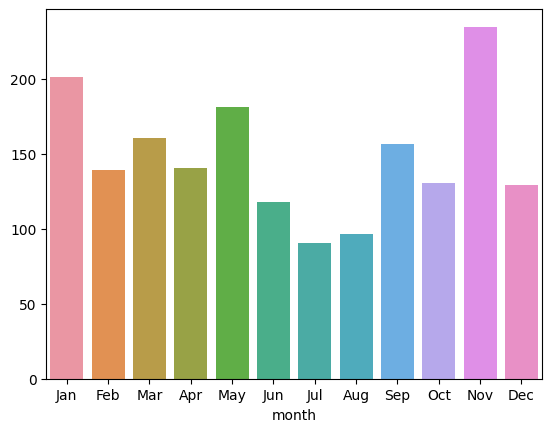

In [24]:
plothpm(hpm(all_streams, average=True))

In [ ]:
all_streams.dtypes

timestamp              datetime64[ns]
playtime_s                      int64
track                          object
artist                         object
album                          object
id                             object
episode                        object
show                           object
spotify_episode_uri            object
shuffle                          bool
playtime_m                    float64
playtime_h                    float64
date                   datetime64[ns]
month                          object
year                            int64
day                            object
dtype: object

In [ ]:
all_streams.sum()

/tmp/ipykernel_27772/2002435790.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_streams.sum()


playtime_s                                             20996817
shuffle                                                    9975
playtime_m                                             349951.5
playtime_h                                               5807.8
month         MarJanDecDecSepJulSepSepJunSepAugAugSepJulSepA...
year                                                  180405489
day           ThuTueThuSatThuMonWedSatWedTueThuWedThuFriThuS...
dtype: object

month
Apr    140.110000
Aug     96.732500
Dec    129.393333
Feb    139.373333
Jan    201.023333
Jul     90.600000
Jun    117.673333
Mar    160.486667
May    181.040000
Nov    234.566667
Oct    130.605000
Sep    156.262500
Name: playtime_h, dtype: float64
month
Apr    420.33
Aug    386.93
Dec    388.18
Feb    418.12
Jan    603.07
Jul    362.40
Jun    353.02
Mar    481.46
May    543.12
Nov    703.70
Oct    522.42
Sep    625.05
Name: playtime_h, dtype: float64


<AxesSubplot: xlabel='month'>

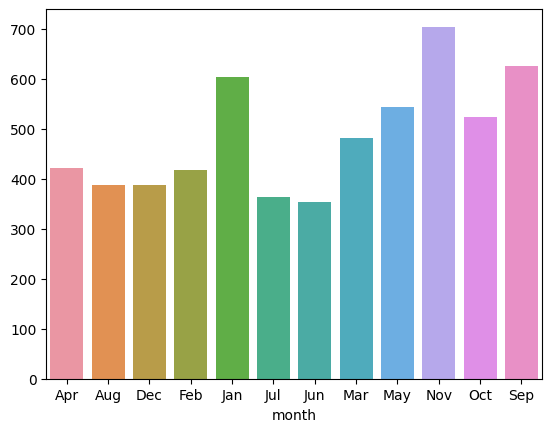

In [ ]:
plothpm(hpm(all_streams))

In [ ]:

music_streams# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.
why_tala = music_streams_no_features#.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.loc[:, ['playtime_s', 'timestamp']].groupby(by=why_tala.timestamp.dt.hour)
    .sum(numeric_only=True)
    .sort_values(by="playtime_s", ascending=False))
why_why_tala["playtime_s"] = why_why_tala["playtime_s"].apply(lambda x: x / 3600)
why_why_tala.head(50)


,playtime_s
timestamp,
5,217.660833
6,213.599722
7,200.713056
4,195.744722
9,177.740278
3,176.846111
2,174.491389
8,172.493056
10,161.819167


In [ ]:
# Looks like I just let her run on most popular song repeat for a few hours.
music_streams_no_features.query('date == "11/27/2019"').sort_values(by="timestamp")


,timestamp,playtime_s,track,artist,album,id,shuffle,playtime_m,playtime_h,date,month,year,day
78510,2019-11-27 05:00:06,162,Blue,Hope Tala,Blue,2jNdYJVaPnG3I4XJApXnZy,False,2.700000,0.045000,2019-11-27,Nov,2019,Wed
54104,2019-11-27 05:03:07,181,Valentine,Hope Tala,Starry Ache,4JoDBcODOajOx3ZRQlSa7o,False,3.016667,0.050278,2019-11-27,Nov,2019,Wed
42212,2019-11-27 05:06:13,185,Sunburn,Hope Tala,Sensitive Soul,5jjTld8YpUHmBbr4SDYmo8,False,3.083333,0.051389,2019-11-27,Nov,2019,Wed
83689,2019-11-27 05:08:18,122,Summer in Paris (Interlude),Hope Tala,Starry Ache,2XsYOvhSLUWgCTM10aZ4CV,False,2.033333,0.033889,2019-11-27,Nov,2019,Wed
60470,2019-11-27 05:11:51,213,Eden,Hope Tala,Starry Ache,6ryhckbki35oQU9AS01JWI,False,3.550000,0.059167,2019-11-27,Nov,2019,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,2019-11-27 22:22:51,207,This Life,Denzel Curry,Imperial,2aQwdBWk4vSPWk1Csgtzdo,False,3.450000,0.057500,2019-11-27,Nov,2019,Wed
44184,2019-11-27 22:26:54,243,Zenith,Denzel Curry,Imperial,67T0J1IDGgRwNMp3vWYaVb,False,4.050000,0.067500,2019-11-27,Nov,2019,Wed
84067,2019-11-27 22:30:50,236,Good Night,Denzel Curry,Imperial,6bcnokzOVQxpn0quzHj6vc,False,3.933333,0.065556,2019-11-27,Nov,2019,Wed
35559,2019-11-28 01:32:49,87,If Tomorrow's Not Here,Denzel Curry,Imperial,3oy9CClx1zCGnhzse9AvDu,False,1.450000,0.024167,2019-11-27,Nov,2019,Wed


In [ ]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2019-09-30,16:57:11,16:57:11,1569801600000,Mon,Sep,2019,119,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,449,2022-05-28,07:32:59,07:32:59,1653696000000,Sat,May,2022,119,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-09-05,03:45:02,03:45:02,1630800000000,Sun,Sep,2021,119,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-05-28,19:22:10,19:22:10,1622160000000,Fri,May,2021,119,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-07-16,20:09:49,20:09:49,1626393600000,Fri,Jul,2021,119,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,199,2022-02-20,22:14:35,22:14:35,1645315200000,Sun,Feb,2022,106,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,220,2019-11-24,20:48:15,20:48:15,1574553600000,Sun,Nov,2019,122,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,435,2022-02-21,18:36:48,18:36:48,1645401600000,Mon,Feb,2022,134,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,417,2020-01-24,23:56:07,23:56:07,1579824000000,Fri,Jan,2020,84,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07


In [ ]:
music_streams

,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,5.85,2021-03-25,Thu,Mar,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26,351,0.10
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,2.60,2021-08-07,Sat,Aug,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-08-07 05:06:29,156,0.04
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,5.85,2021-01-21,Thu,Jan,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09,351,0.10
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,0.00,2019-10-18,Fri,Oct,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 18:04:48,0,0.00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,0.03,2022-02-17,Thu,Feb,2022,161,12A,D-flat minor,True,1qXLj4ywjsA0hGmaibmnn3,2022-02-17 11:15:58,2,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85407,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,3.93,2022-09-29,Thu,Sep,2022,100,6B,B-flat major,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58,236,0.07
85408,Teitanblood,Anteinfierno,Death,297,4.95,2021-09-24,Fri,Sep,2021,101,6A,G minor,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37,297,0.08
85409,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,3.20,2019-12-05,Thu,Dec,2019,112,11B,A major,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04,192,0.05
85410,Master P,Meal Ticket,I'm Bout It,244,4.07,2021-01-18,Mon,Jan,2021,152,10B,D major,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48,244,0.07


In [ ]:
music_streams.sort_values(by="playtime_s")

,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
47809,Ludwig van Beethoven,"Piano Sonata No. 11 In B Flat Major, Op. 22: 4...",Beethoven: The Piano Sonatas,371,0.00,2020-04-04,Sat,Apr,2020,131,6B,B-flat major,False,4W1CenpP9ZxvSwhRHkgVF6,2020-04-04 14:15:08,0,0.00
3782,Main Source,Just a Friendly Game of Baseball - 2017 Remast...,Breaking Atoms,202,0.00,2021-05-07,Fri,May,2021,94,11A,F-sharp minor,False,3gI4WHUyXCP96IQb9hzxnJ,2021-05-07 14:13:54,0,0.00
16421,Aphex Twin,Nanou2,Drukqs,205,0.00,2020-01-04,Sat,Jan,2020,93,4B,A-flat major,False,6Wei2NUSG66WzLiqSuQAy5,2020-01-04 05:15:09,0,0.00
82851,Sasha Carassi,Nomads,Kill The Monster EP,416,0.00,2022-04-15,Fri,Apr,2022,122,12A,D-flat minor,False,6z8CNKl6hK2yAvqnUXZeoU,2022-04-15 10:01:06,0,0.00
69678,Y1640,Spit Intent,Spit Intent,259,0.00,2020-04-04,Sat,Apr,2020,150,8B,C major,False,0id4Rkg8xaN68PKcIHCfAp,2020-04-04 17:47:22,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82774,William Basinski,El Camino Real,El Camino Real,3000,50.00,2021-01-28,Thu,Jan,2021,142,3B,D-flat major,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11,3000,0.83
64071,William Basinski,dlp 5,The Disintegration Loops III,3141,52.35,2021-02-02,Tue,Feb,2021,135,7B,F major,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46,3141,0.87
67998,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2022-07-26,Tue,Jul,2022,95,7B,F major,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01,3816,1.06
70705,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2021-01-28,Thu,Jan,2021,95,7B,F major,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35,3816,1.06


In [ ]:
top_songs(music_streams_no_features, skips=True).head(30)


,,0
artist,track,
Teebs,Black Dove,124
myNoise,Stereo Left-Right (Test Only),119
Hope Tala,Moontime,108
Andy Stott,New Romantic,100
Dope Saint Jude,Grrrl Like,97
Aphex Twin,Alberto Balsalm,94
Teebs,Studie,92
SUPEREGO,O.B.S (Outer Body Stranger) [feat. Sampa the Great],90
Low Leaf,Go Go Go,83


In [ ]:
pivot_track = pd.DataFrame(
    no_skip_df.query('year == 2022')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False))

pivot_track.head(30)


0
artist            track                                              year    
Rvdical the Kid   Nasa                                               2022  23
Pusha T           Brambleton                                         2022  23
Lava La Rue       G.O.Y.D.                                           2022  22
                  Cry Baby                                           2022  17
Billy Lemos       Midlife Crisis                                     2022  17
Dua Saleh         signs                                              2022  16
JPEGMAFIA         HAZARD DUTY PAY!                                   2022  16
SZA               Jodie                                              2022  16
Caroline Polachek So Hot You're Hurting My Feelings                  2022  15
Angel Haze        Never Seen                                         2022  15
Ari Lennox        Yuengling                                          2022  15
Vince Staples     AYE! (FREE THE HOMIES)                             2022  14
Denzel Curry      The Ills                                           2022  14
Lava La Rue       Don't Come Back                                    2022  14
Doechii           Yucky Blucky Fruitcake                             2022  13
Wombo             Below the House                                    2022  13
Sudan Archives    #513                                               2022  13
Cocteau Twins     Pandora (for Cindy)                                2022  12
Lava La Rue       Magpie (feat. Congo Natty & Phoebs) - Nia Archi... 2022  12
Sudan Archives    Selfish Soul                                       2022  12
Smino             Father Son Holy Smoke                              2022  12
Cartel Madras     WORKING                                            2022  11
SZA               2AM                                                2022  11
Lava La Rue       Hi-Fidelity                                        2022  11
DijahSB           By Myself                                          2022  11
Dawn Richard      Nostalgia                                          2022  11
Jamila Woods      EARTHA                                             2022  10
H31R              accountability                                     2022  10
Lava La Rue       Don't Trip                                         2022  10
Chavo             Had A Feeling (Remix)                              2022  10

In [ ]:
no_skip_df.query('year == 2022')


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
6,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2022-09-13,01:43:38,01:43:38,1663027200000,Tue,Sep,2022,161,12A,D-flat minor,fwdbtn,trackdone,True,1qXLj4ywjsA0hGmaibmnn3,2022-09-13 06:43:38
17,The Roots,You Got Me - Drum & Bass Mix,Things Fall Apart,298,298,2022-09-27,16:56:45,16:56:45,1664236800000,Tue,Sep,2022,162,10A,B minor,trackdone,trackdone,True,3aljYEbx7GiJraSrIu82kd,2022-09-27 21:56:45
19,DETO BLACK,Brag,Brag,121,121,2022-07-22,10:40:34,10:40:34,1658448000000,Fri,Jul,2022,91,4A,F minor,trackdone,trackdone,True,4YJ9QxYTunZGun6IsUM7kz,2022-07-22 15:40:34
20,DETO BLACK,Brag,Brag,121,121,2022-09-24,20:43:58,20:43:58,1663977600000,Sat,Sep,2022,91,4A,F minor,fwdbtn,trackdone,True,4YJ9QxYTunZGun6IsUM7kz,2022-09-25 01:43:58
21,Magdalena Bay,Killshot - Slowed + Reverb,Killshot,278,280,2022-09-15,18:41:04,18:41:04,1663200000000,Thu,Sep,2022,84,3B,D-flat major,backbtn,trackdone,True,6pdyvJQkPkwo2WoDH7tFHO,2022-09-15 23:41:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47922,Grizzly Bear,Half Gate,Shields,330,330,2022-04-02,18:22:34,18:22:34,1648857600000,Sat,Apr,2022,85,7B,F major,trackdone,trackdone,True,1hEJVJBq6WYSrjKCczuvSt,2022-04-02 23:22:34
47923,KAINA,It Was a Home,It Was a Home,215,215,2022-03-06,21:53:34,21:53:34,1646524800000,Sun,Mar,2022,164,11B,A major,trackdone,trackdone,False,7rIkH904aCexVHirV2Auwg,2022-03-07 02:53:34
47924,Bas Mooy,Bloedneus,Alliance VI,343,343,2022-02-28,20:17:31,20:17:31,1646006400000,Mon,Feb,2022,136,9B,G major,trackdone,trackdone,False,5agAhZMQ9a5dBtbgAt4S0y,2022-03-01 01:17:31
47930,Charles Stepney,Step on Step,Step on Step,237,237,2022-06-08,05:47:43,05:47:43,1654646400000,Wed,Jun,2022,105,8B,C major,fwdbtn,trackdone,False,16JGYp893Nuk81wo6SscAk,2022-06-08 10:47:43


In [ ]:
# # Check for tracks missing from new df
# series1 = duration_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [ ]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [ ]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


0
artist           track                             
myNoise          Stereo Left-Right (Test Only)  118
Teebs            Black Dove                     100
Hope Tala        Moontime                        89
Teebs            Studie                          76
Aphex Twin       Alberto Balsalm                 65
...                                             ...
Derrick Harriott I Don't Want to Cry              1
                 Have You Seen Her                1
Machinefabriek   Zucht 2                          1
Mackk            Forever - Cleo Reed Remix        1
박혜진 Park Hye Jin Like this                        1

[18698 rows x 1 columns]

In [ ]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


,0
artist,
Solange,682
Teebs,569
Frank Ocean,490
Noname,475
Tim Hecker,463
...,...
Monster Rally,1
Contours,1
Conway Twitty,1


In [ ]:
no_skip_df


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-03-25,13:43:26,13:43:26,1616630400000,Thu,Mar,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-01-21,00:42:09,00:42:09,1611187200000,Thu,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,434,2021-05-06,15:25:54,15:25:54,1620259200000,Thu,May,2021,161,12A,D-flat minor,fwdbtn,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-05-06 20:25:54
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-01-15,20:47:55,20:47:55,1610668800000,Fri,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-16 01:47:55
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-01-30,00:14:21,00:14:21,1611964800000,Sat,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-30 05:14:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47933,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,236,2022-09-29,22:19:58,22:19:58,1664409600000,Thu,Sep,2022,100,6B,B-flat major,trackdone,trackdone,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58
47934,Teitanblood,Anteinfierno,Death,297,297,2021-09-24,23:34:37,23:34:37,1632441600000,Fri,Sep,2021,101,6A,G minor,clickrow,trackdone,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37
47935,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,192,2019-12-05,23:52:04,23:52:04,1575504000000,Thu,Dec,2019,112,11B,A major,trackdone,trackdone,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04
47936,Master P,Meal Ticket,I'm Bout It,244,244,2021-01-18,20:55:48,20:55:48,1610928000000,Mon,Jan,2021,152,10B,D major,trackdone,trackdone,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48


In [ ]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime_s", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime_s", ascending=False)
miles


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2019-09-30,16:57:11,16:57:11,1569801600000,Mon,Sep,2019,119,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,449,2022-05-28,07:32:59,07:32:59,1653696000000,Sat,May,2022,119,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-09-05,03:45:02,03:45:02,1630800000000,Sun,Sep,2021,119,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-05-28,19:22:10,19:22:10,1622160000000,Fri,May,2021,119,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-07-16,20:09:49,20:09:49,1626393600000,Fri,Jul,2021,119,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,199,2022-02-20,22:14:35,22:14:35,1645315200000,Sun,Feb,2022,106,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,220,2019-11-24,20:48:15,20:48:15,1574553600000,Sun,Nov,2019,122,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,435,2022-02-21,18:36:48,18:36:48,1645401600000,Mon,Feb,2022,134,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,417,2020-01-24,23:56:07,23:56:07,1579824000000,Fri,Jan,2020,84,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07


In [ ]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["album"], aggfunc="sum"
)


In [ ]:
pivot_album_time = pivot_album_time.sort_values(by="playtime_s", ascending=False)
pivot_album_time.head(20)


,playtime_s
album,
Anicca,78788
Blonde,63915
MAGDALENE,63106
When I Get Home,61274
Radio Amor,59900
Portrait with Firewood,52849
Couldn't Wait to Tell You...,51087
Take Me Apart,48455
It Should Be Us,40426


In [ ]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["artist"], aggfunc="sum"
)


In [ ]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime_h", ascending=False
).reset_index()
print(artist_time.to_string())


KeyError: 'playtime_h'

In [ ]:
test_music_streams_no_features

In [ ]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(music_streams["track"].unique())


In [ ]:
still_repeated = repeated_artists["artist"]


In [ ]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [ ]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [ ]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [ ]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [ ]:
pivot_artist_time.playtime_s


In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should explore more of.
pivot_artist_time.query("playtime_s > 3600").query("artist in @unique_export")


In [ ]:
# Show longest songs
no_skip_df.sort_values(by="playtime_s", axis=0, ascending=False)


In [ ]:
music_streams.query('year == 2019')

In [ ]:
# How to control this for missing months? do october 25 2019 thru 2022
plt.rcParams['figure.figsize']=(8,8)
sns_prep = music_streams.query('year == 2019| year == 2020 | year == 2021')
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime_s",
    index=sns_prep.timestamp.dt.strftime("%b"),
    aggfunc="sum",
).reset_index()
sns_prep["playtime_h"] = sns_prep["playtime_s"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x=sns_prep.index, y="playtime_h")


In [ ]:
# sum of unique uris closely maps to total skips per month
sns_prep = music_streams.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# good way to find months with most music discovery along with unique URIs
sns_prep = music_streams.copy().query("(playtime_s / duration) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"]
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


In [ ]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    music_streams, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


In [ ]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
music_streams.query("(playtime_s / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


In [ ]:
# Todo: plot podcast listening vs music listening
# Totals per month
podcasts_2020 = podcasts.copy()
podcasts_2020["playtime_s"] = podcasts_2020["playtime_s"].copy() / 3600
podcast_per_month = podcasts_2020.groupby(by="month").sum(numeric_only=True)
podcast_per_month["playtime_s"]
sns.barplot(
    data=podcast_per_month, x=podcast_per_month["playtime_s"], y=podcast_per_month.index
)


In [ ]:
# Todo: plot podcast listening vs music listening
# damn i really spent most of january 2022 listening to podcats

plothpm(hpm(no_skip_df))